In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,  "/project/remote/pento-diaref")

In [2]:
import collections
import pandas as pd
import seaborn as sns
import itertools
import numpy as np
import random
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from pentodiaref.data.generation.types import Annotation
from golmi.contrib.pentomino.symbolic.types import PropertyNames, Colors, Shapes, RelPositions, Rotations

In [3]:
data_dir = "/data/pento_diaref/didact"
file_name = "data_train"
samples = Annotation.load(data_dir, file_name, resolve=True)

Resolve data types


100%|██████████| 128526/128526 [00:09<00:00, 14072.64it/s]


Loaded 128526 from /data/pento_diaref/didact/data_train.json


In [4]:
piece_sets = [s.group for s in samples]
print("Sets:", len(piece_sets), "Uniq Sets:",len(set(piece_sets)))

Sets: 128526 Uniq Sets: 41734


In [5]:
# For a single 
# piece config (COLOR,SHAPE,POSITION) 
# in different contexts, how often differs the utterance-type?
def count_piece_config_utterance_freq(samples, pref_order=None):
    freqs = collections.defaultdict(lambda: collections.defaultdict(int))
    utterance_types = set()
    for s in samples:
        target = s.group[s.target_idx]
        for ref in s.refs:
            if pref_order:
                if tuple(ref["props_pref"]) != tuple(pref_order):
                    continue
            utterance_type = tuple(sorted(list(ref.property_values.keys())))
            utterance_types.add(utterance_type)
            freqs[target][utterance_type] += 1
    return freqs, utterance_types

#piece_utterance_freqs, utterance_types = count_piece_utterance_freq(samples, pref_order=['color', 'shape', 'rel_position'])
piece_config_utterance_freqs, utterance_types = count_piece_config_utterance_freq(samples)

In [6]:
utterance_types =[
    (PropertyNames.SHAPE,),
    (PropertyNames.COLOR,),
    (PropertyNames.COLOR, PropertyNames.REL_POSITION),
    (PropertyNames.COLOR, PropertyNames.SHAPE),
    (PropertyNames.COLOR, PropertyNames.REL_POSITION, PropertyNames.SHAPE),
    (PropertyNames.REL_POSITION, PropertyNames.SHAPE),
    (PropertyNames.REL_POSITION,),
]

In [7]:
mean_utterance_type_per_piece_config = dict()
for idx, utterance_type in enumerate(utterance_types):
    occurrences = [piece_config_utterance_freqs[piece][utterance_type] for piece in piece_config_utterance_freqs]
    v = np.mean(occurrences)
    mean_utterance_type_per_piece_config[utterance_type] = v
    print(idx, "{:<30} avg: {:>3} abs: {}".format(str(utterance_type), round(v), np.sum(occurrences)))
print("total avg. types per piece config:", round(sum([v for v in mean_utterance_type_per_piece_config.values()])))


df_utterance_type_per_piece_config = pd.DataFrame.from_records(
    [{"Index": idx, "Count": v} for idx, (k,v) in enumerate(mean_utterance_type_per_piece_config.items())])

0 (shape,)                       avg:  17 abs: 14214
1 (color,)                       avg:  28 abs: 23821
2 (color, rel_position)          avg:  24 abs: 19853
3 (color, shape)                 avg:  20 abs: 17048
4 (color, rel_position, shape)   avg:  12 abs: 9797
5 (rel_position, shape)          avg:  27 abs: 22621
6 (rel_position,)                avg:  25 abs: 21172
total avg. types per piece config: 153


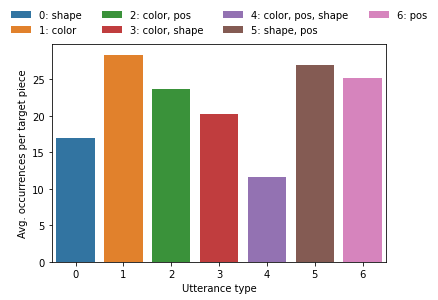

In [8]:
ax = sns.barplot(x="Index", y="Count", hue="Index", dodge=False, data=df_utterance_type_per_piece_config)
h, l = ax.get_legend_handles_labels()
ax.set_ylabel("Avg. occurrences per target piece")
ax.set_xlabel("Utterance type")
ax.legend(h, [
    "0: shape",
    "1: color",
    "2: color, pos",
    "3: color, shape",
    "4: color, pos, shape",
    "5: shape, pos",
    "6: pos"
])
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False,
)
plt.show()